In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm

C:\Users\cyun9\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Env():
    def __init__(self, n_action):
        self.n_action = n_action 
        self.init_states()

    def init_states(self):
        # 실제 Optimal q value 생성
        self.optimal_q_value_list = [np.random.normal(loc = 0, scale = 1) for i in range(self.n_action)]

    def get_reward(self, action:int):
        '''
        - Desc - 
        Action 값을 넣었을 때 해당 Action에 맞는 optimal_q 값으로부터 Reward 값을 반환 
        Reward 값은 평균이 실제 Optimal_q 값이고 variance가 1인 Normal Distribution 
        
        '''
        # reward distribution 생성
        return np.random.normal(loc = self.optimal_q_value_list[action], scale = 1)
    
    def gen_random_reward(self, n):
        '''
        각 Action 별로 n개씩의 reward를 sampling.  
        
        '''
        
        data_list = []
        
        for iter in range(n):
            data_list.extend([[i+1, self.get_reward(i)] for i in range(self.n_action)])
            
        return pd.DataFrame(data_list, columns=['x', 'reward'])

## Greedy Method Vs. $\epsilon$-greedy Method

### Agent Class

In [3]:
class Agent():
    def __init__(self, n_action):
        self.n_action = n_action 
        self.init_values()

    def init_values(self):
        # 실제 optimal q value 생성 
        self.pred_q_value_list = [0 for _ in range(self.n_action)]
        self.reward_history = pd.DataFrame(columns=['action', 'q_value'])
        self.reward_history = self.reward_history.astype({'action':'str', 'q_value':'float'}) 

    def step(self, env, epsilon):
        '''
        한번의 time step 을 진행.
        
        '''
        # 1. epsilon 값에 따라 Action 선택 및 reward를 받음
        if epsilon > np.random.rand(1): 
            action = self.get_random_action()
        else : 
            action = self.get_greedy_action()

        reward = env.get_reward(action)

        # 2. reward_history 에 저장 
        self.reward_history.loc[len(self.reward_history)] = [str(action), reward]

        # 3. 선택된 Action의 Expected Reward 값 (q_value_list)을 업데이트. 
        self.update_Q_value(action)

    def update_Q_value(self, action):
        '''
        - Desc -
        특정 Action에 대한 self.Q_value를 업데이트.
        
        - Input - 
        action(int): 업데이트할 Action 번호  
        
        - Output -
        None 
        '''
        self.pred_q_value_list[action] = self.reward_history[self.reward_history.action == str(action)]['q_value'].mean()

    def get_greedy_action(self):
        max_value = np.max(self.pred_q_value_list)
        max_actions = np.where(self.pred_q_value_list == max_value)[0]
        selected_action = np.random.choice(max_actions)
        return selected_action

    def get_random_action(self):
        random_action = np.random.randint(self.n_action)
        return random_action

### Greedy and $\epsilon$-Greedy 

In [4]:
def experiment(n_action, n_episode, n_step, epsilon):
    env = Env(n_action)
    agent = Agent(n_action)

    episode_reward_list = []
    episode_action_tf_list = []
    
    for run in tqdm(range(n_episode)):
        env.init_states()
        agent.init_values()
        best_action = np.argmax(env.optimal_q_value_list)
        
        for step in range(n_step):
            agent.step(env, epsilon)
            
        reward_list = agent.reward_history['q_value'].tolist()        
        action_tf_list = (agent.reward_history['action'] == str(best_action)).tolist()
        
        episode_reward_list.append(reward_list)
        episode_action_tf_list.append(action_tf_list)
        
    return episode_reward_list, episode_action_tf_list

In [5]:
# Run 
n_run = 2 # 2000
n_step = 1000
n_action = 10
env = Env(n_action)
agent = Agent(n_action)
epsilon = 0.0

In [6]:
exp1_reward_list, exp1_action_list = experiment(n_action, n_episode=500, n_step = 1000, epsilon=0.0)
exp2_reward_list, exp2_action_list = experiment(n_action, n_episode=500, n_step = 1000, epsilon=0.01)
exp3_reward_list, exp3_action_list = experiment(n_action, n_episode=500, n_step = 1000, epsilon=0.1)

100%|██████████| 500/500 [12:52<00:00,  1.54s/it]


In [7]:
exp1_reward_pd = [pd.DataFrame(x) for x in exp1_reward_list]
exp2_reward_pd = [pd.DataFrame(x) for x in exp2_reward_list]
exp3_reward_pd = [pd.DataFrame(x) for x in exp3_reward_list]

exp1_action_pd = [pd.DataFrame(x) for x in exp1_action_list]
exp2_action_pd = [pd.DataFrame(x) for x in exp2_action_list]
exp3_action_pd = [pd.DataFrame(x) for x in exp3_action_list]

exp1_reward_avg = pd.concat(exp1_reward_pd, axis = 1).mean(axis=1)
exp2_reward_avg = pd.concat(exp2_reward_pd, axis = 1).mean(axis=1)
exp3_reward_avg = pd.concat(exp3_reward_pd, axis = 1).mean(axis=1)

exp1_action_avg = pd.concat(exp1_action_pd, axis = 1).mean(axis=1)
exp2_action_avg = pd.concat(exp2_action_pd, axis = 1).mean(axis=1)
exp3_action_avg = pd.concat(exp3_action_pd, axis = 1).mean(axis=1)

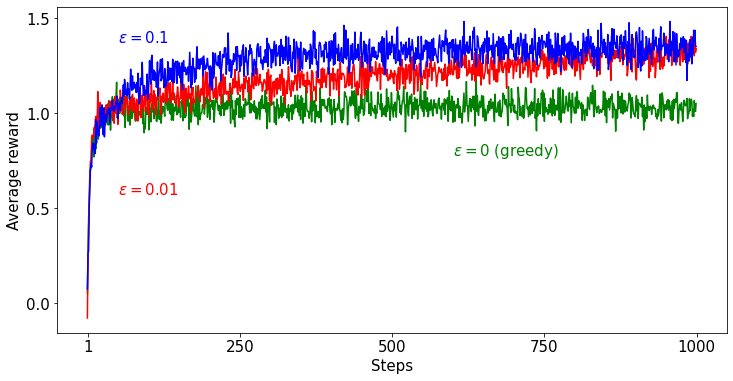

In [8]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.figure(figsize = (12, 6))
plt.plot(exp1_reward_avg, 'g')
plt.text(600, 0.8, f'$\epsilon = 0$ (greedy)', fontsize=15, ha = 'left', va='center', color='g')
plt.plot(exp2_reward_avg, 'r')
plt.text(50, 0.6, f'$\epsilon = 0.01$', fontsize=15, ha = 'left', va='center', color='r')
plt.plot(exp3_reward_avg, 'b')
plt.text(50, 1.4, f'$\epsilon = 0.1$', fontsize=15, ha = 'left', va='center', color='b')
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Average reward', fontsize=15)
plt.xticks([1, 250, 500, 750, 1000])
plt.yticks([0, 0.5, 1, 1.5])
plt.show()

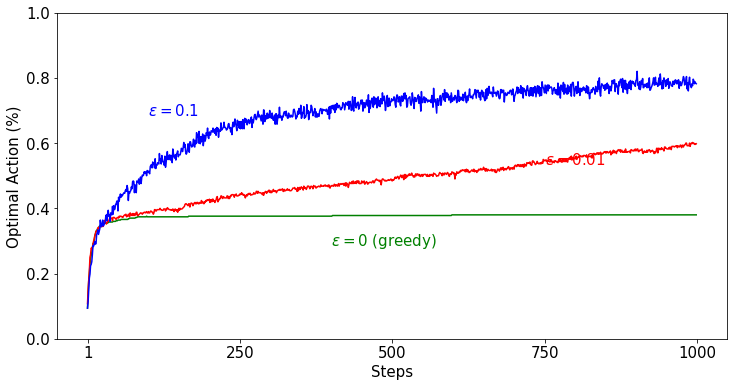

In [9]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.figure(figsize = (12, 6))
plt.plot(exp1_action_avg, 'g')
plt.text(400, 0.3, f'$\epsilon = 0$ (greedy)', fontsize=15, ha = 'left', va='center', color='g')
plt.plot(exp2_action_avg, 'r')
plt.text(750, 0.55, f'$\epsilon = 0.01$', fontsize=15, ha = 'left', va='center', color='r')
plt.plot(exp3_action_avg, 'b')
plt.text(100, 0.7, f'$\epsilon = 0.1$', fontsize=15, ha = 'left', va='center', color='b')
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Optimal Action (%)', fontsize=15)
plt.xticks([1, 250, 500, 750, 1000])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

## Incremental Implementation

### Agent Class

In [10]:
class Agent():
    def __init__(self, n_action):
        self.n_action = n_action 
        self.init_values()

    def init_values(self):
        # 실제 optimal q value 생성 
        self.pred_q_value_list = [0 for _ in range(self.n_action)]
        self.n_list = [0 for _ in range(self.n_action)]
        
    def step(self, env, epsilon):
        '''
        한번의 time step 을 진행.
        
        '''
        # 1. epsilon 값에 따라 Action 선택 및 reward를 받음
        if epsilon > np.random.rand(1): 
            action = self._get_random_action()
        else : 
            action = self._get_greedy_action()

        reward = env.get_reward(action)

        # 2. n 값 증가 
        self.n_list[action] = self.n_list[action] + 1

        # 3. 선택된 Action의 Expected Reward 값 (q_value_list)을 업데이트. 
        self.pred_q_value_list[action] = self.pred_q_value_list[action] + (reward - self.pred_q_value_list[action]) / self.n_list[action]

        return action, reward

    def _get_greedy_action(self):
        max_value = np.max(self.pred_q_value_list)
        max_actions = np.where(self.pred_q_value_list == max_value)[0]
        selected_action = np.random.choice(max_actions)
        return selected_action

    def _get_random_action(self):
        random_action = np.random.randint(self.n_action)
        return random_action

### Greedy and $\epsilon$-Greedy 

In [11]:
def experiment(n_action, n_episode, n_step, epsilon):
    env = Env(n_action)
    agent = Agent(n_action)

    episode_reward_list = []
    episode_action_tf_list = []
    
    for run in tqdm(range(n_episode)):
        env.init_states()
        agent.init_values()
        best_action = np.argmax(env.optimal_q_value_list)
        
        reward_list = []
        action_tf_list = []
        for step in range(n_step):
            action, reward = agent.step(env, epsilon)
            
            reward_list.append(reward)        
            action_tf_list.append(action == best_action)
        
        episode_reward_list.append(reward_list)
        episode_action_tf_list.append(action_tf_list)
        
    return episode_reward_list, episode_action_tf_list

In [12]:
# Run 
n_run = 2 # 2000
n_step = 1000
n_action = 10
env = Env(n_action)
agent = Agent(n_action)
epsilon = 0.0

In [13]:
exp1_reward_list, exp1_action_list = experiment(n_action, n_episode=500, n_step = 1000, epsilon=0.0)
exp2_reward_list, exp2_action_list = experiment(n_action, n_episode=500, n_step = 1000, epsilon=0.01)
exp3_reward_list, exp3_action_list = experiment(n_action, n_episode=500, n_step = 1000, epsilon=0.1)

100%|██████████| 500/500 [00:17<00:00, 28.75it/s]


In [14]:
exp1_reward_pd = [pd.DataFrame(x) for x in exp1_reward_list]
exp2_reward_pd = [pd.DataFrame(x) for x in exp2_reward_list]
exp3_reward_pd = [pd.DataFrame(x) for x in exp3_reward_list]

exp1_action_pd = [pd.DataFrame(x) for x in exp1_action_list]
exp2_action_pd = [pd.DataFrame(x) for x in exp2_action_list]
exp3_action_pd = [pd.DataFrame(x) for x in exp3_action_list]

exp1_reward_avg = pd.concat(exp1_reward_pd, axis = 1).mean(axis=1)
exp2_reward_avg = pd.concat(exp2_reward_pd, axis = 1).mean(axis=1)
exp3_reward_avg = pd.concat(exp3_reward_pd, axis = 1).mean(axis=1)

exp1_action_avg = pd.concat(exp1_action_pd, axis = 1).mean(axis=1)
exp2_action_avg = pd.concat(exp2_action_pd, axis = 1).mean(axis=1)
exp3_action_avg = pd.concat(exp3_action_pd, axis = 1).mean(axis=1)

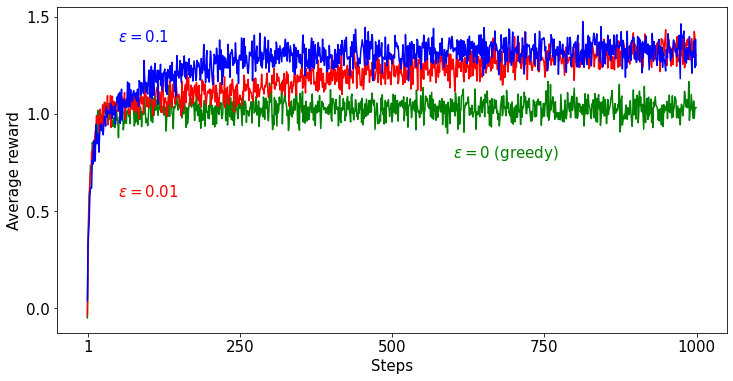

In [15]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.figure(figsize = (12, 6))
plt.plot(exp1_reward_avg, 'g')
plt.text(600, 0.8, f'$\epsilon = 0$ (greedy)', fontsize=15, ha = 'left', va='center', color='g')
plt.plot(exp2_reward_avg, 'r')
plt.text(50, 0.6, f'$\epsilon = 0.01$', fontsize=15, ha = 'left', va='center', color='r')
plt.plot(exp3_reward_avg, 'b')
plt.text(50, 1.4, f'$\epsilon = 0.1$', fontsize=15, ha = 'left', va='center', color='b')
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Average reward', fontsize=15)
plt.xticks([1, 250, 500, 750, 1000])
plt.yticks([0, 0.5, 1, 1.5])
plt.show()

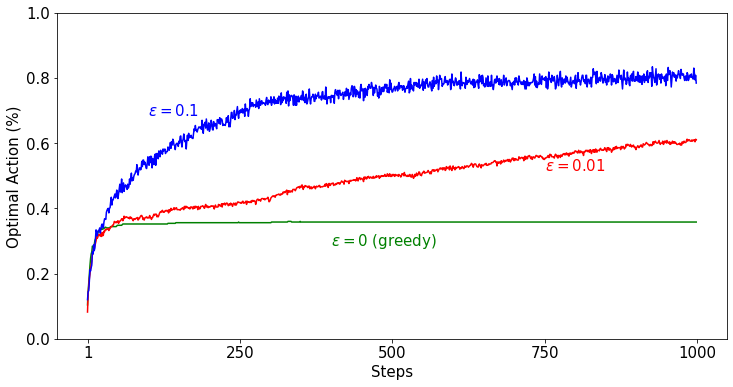

In [16]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.figure(figsize = (12, 6))
plt.plot(exp1_action_avg, 'g')
plt.text(400, 0.3, f'$\epsilon = 0$ (greedy)', fontsize=15, ha = 'left', va='center', color='g')
plt.plot(exp2_action_avg, 'r')
plt.text(750, 0.53, f'$\epsilon = 0.01$', fontsize=15, ha = 'left', va='center', color='r')
plt.plot(exp3_action_avg, 'b')
plt.text(100, 0.7, f'$\epsilon = 0.1$', fontsize=15, ha = 'left', va='center', color='b')
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Optimal Action (%)', fontsize=15)
plt.xticks([1, 250, 500, 750, 1000])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()